## Analysis of IMDB Movie Reviews

Now for a little practice! We want to solve the problem of binary classification of IMDB movie reviews. We have a training set with marked reviews, 12500 reviews marked as good, another 12500 bad. Here, it’s not easy to get started with machine learning right away because we don’t have the matrix 
$X$; we need to prepare it. We will use a simple approach: bag of words model. Features of the review will be represented by indicators of the presence of each word from the whole corpus in this review. The corpus is the set of all user reviews.

In [7]:
import os 
import numpy as np
import matplotlib.pyplot as plt

#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

We download and exctract the file here.

In [8]:
import tarfile
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path, overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)



In [9]:
DATA_PATH = "../../_static/data/"

load_imdb_dataset(extract_path=DATA_PATH)

IMDB dataset is already in place.


In [10]:
# change if you have it in alternative location
PATH_TO_IMDB = DATA_PATH + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [11]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


Lets look at some examples of a the reviews

In [12]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [13]:
y_train[1]  # bad review

np.int64(0)

In [14]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [15]:
y_train[2]  # good review

np.int64(1)

## Simple Word Count

We shall create a dictionary with all the words using CountVectorizer

In [16]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

If you look at the examples of “words” (let’s call them tokens), you can see that we have omitted many of the important steps in text processing (automatic text processing can itself be a completely separate series of articles).

In [17]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


Secondly, we are encoding the sentences from the training set texts with the indices of incoming words. We’ll use the sparse format.

In [18]:
X_train = cv.transform(text_train)
X_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3445861 stored elements and shape (25000, 74849)>

Let’s see how our transformation worked

In [19]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [20]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [21]:
X_train[19726].nonzero()


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

Third, we will apply the same operations to the test set

In [22]:
X_test = cv.transform(text_test)

Next we train Logistic Regression the Training Set

In [23]:
%%time
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: total: 422 ms
Wall time: 6.6 s


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,7
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Lets see the accuracy score on both the train and test dataset

In [24]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

Lets try to visualise the coefficients of our model

In [25]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [26]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

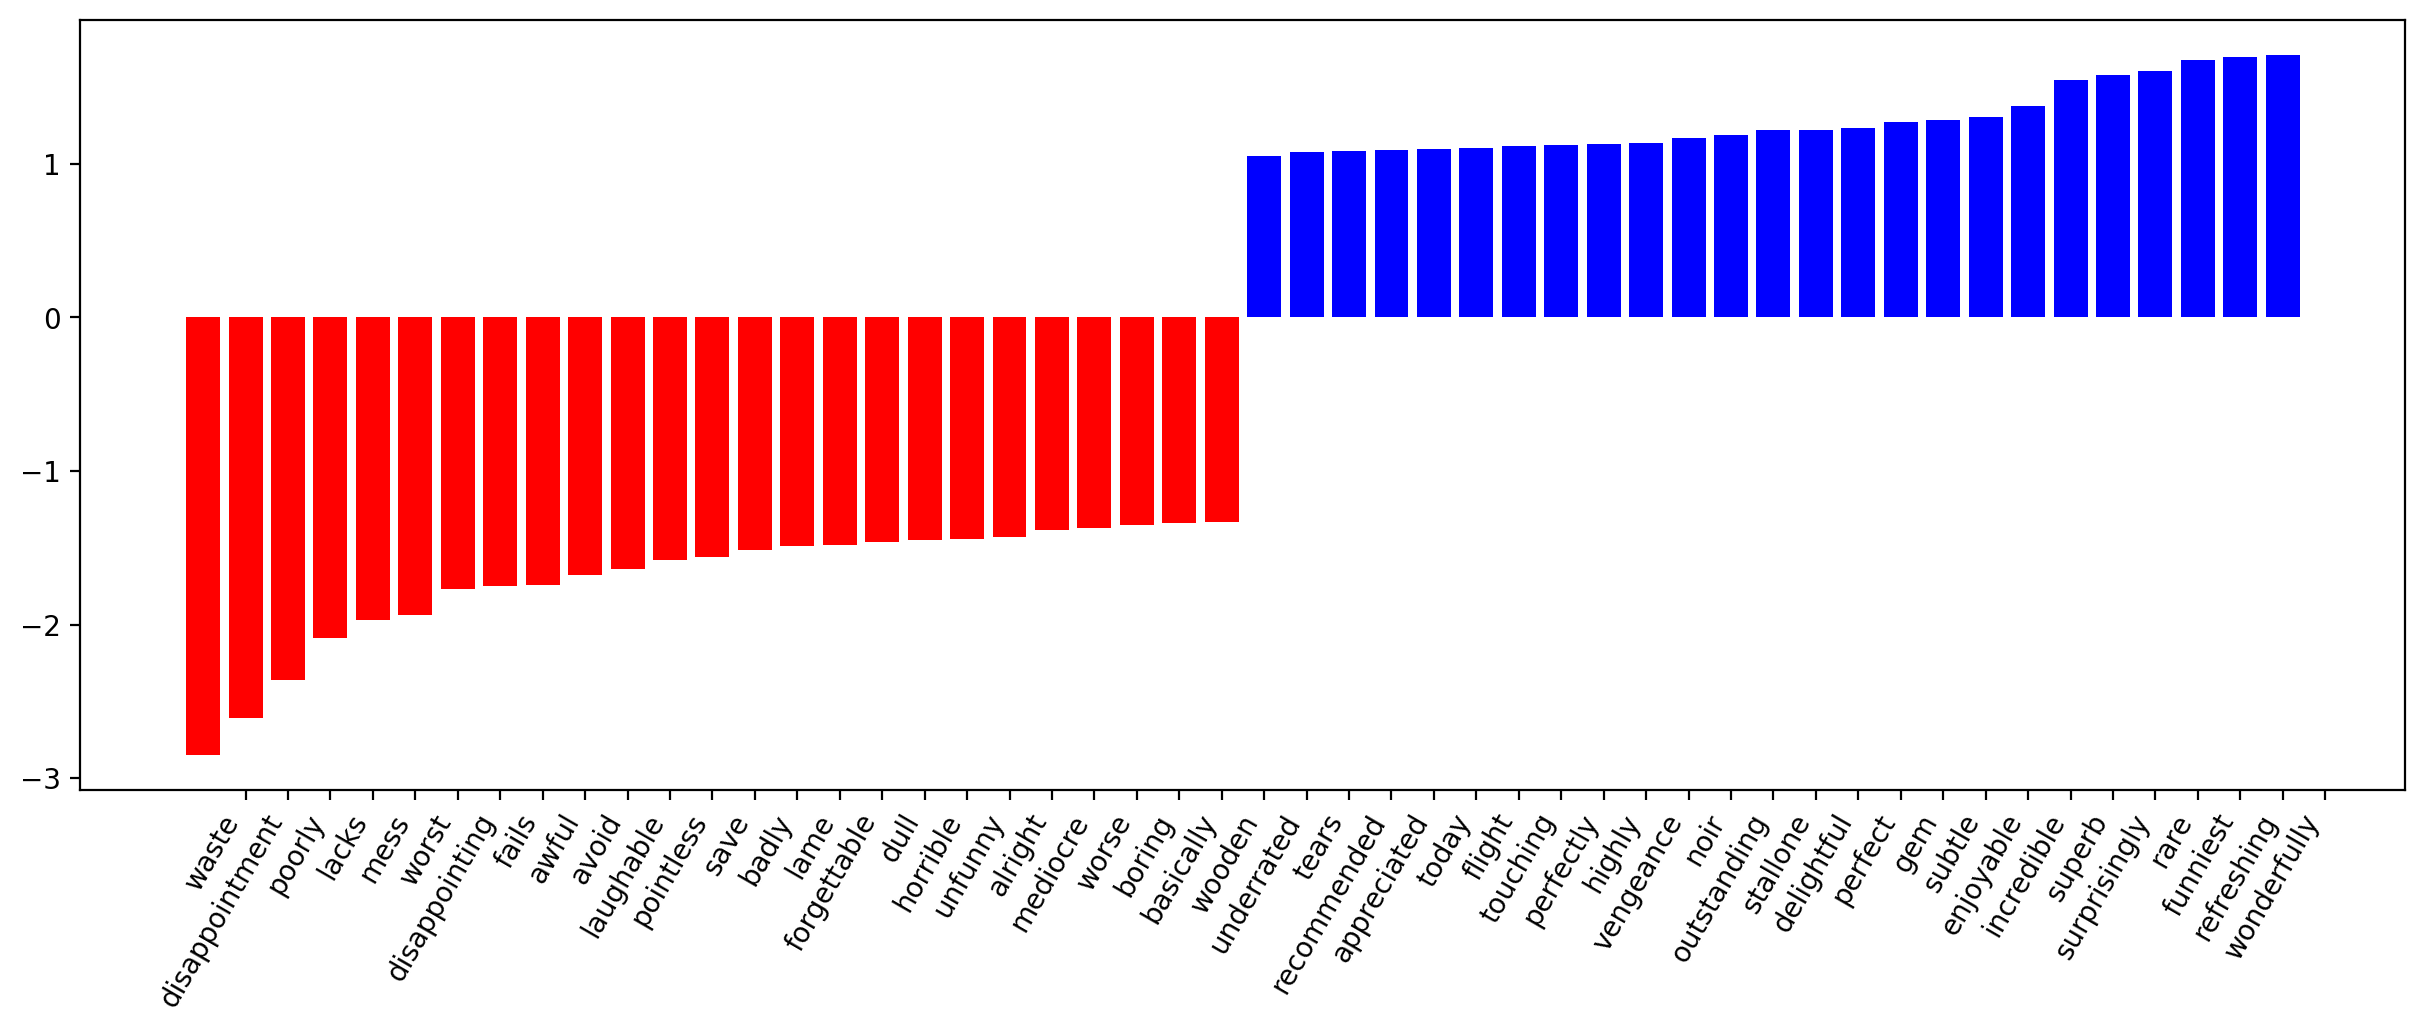

In [27]:
visualize_coefficients(logit, cv.get_feature_names_out());

To make our model better, we can optimize the regularization coefficient for the Logistic Regression. We’ll use sklearn.pipeline because CountVectorizer should only be applied to the training data (so as to not “peek” into the test set and not count word frequencies there). In this case, pipeline determines the correct sequence of actions: apply CountVectorizer, then train Logistic Regression.

In [29]:
%%time

from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(),
    LogisticRegression(solver="lbfgs", n_jobs=1, random_state=7)
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test , y_test))

c:\Internship Applications\Python\mlcourse_ai\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.86388
CPU times: total: 13.3 s
Wall time: 13.7 s


In [33]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid_logit = {
    "logisticregression__C" : np.logspace(-5 , 0 , 6)
}


grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit , cv=3 , n_jobs = -1 , return_train_score=True
)


grid_logit.fit(text_train, y_train)

CPU times: total: 11.3 s
Wall time: 42.4 s


c:\Internship Applications\Python\mlcourse_ai\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,estimator,Pipeline(step...om_state=7))])
,param_grid,"{'logisticregression__C': array([1.e-05...e-01, 1.e+00])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,input,'content'


Let’s print best $C$ and cv-score using this hyperparameter:

In [34]:
grid_logit.best_params_ , grid_logit.best_score_

({'logisticregression__C': np.float64(0.1)}, np.float64(0.8852799228359823))

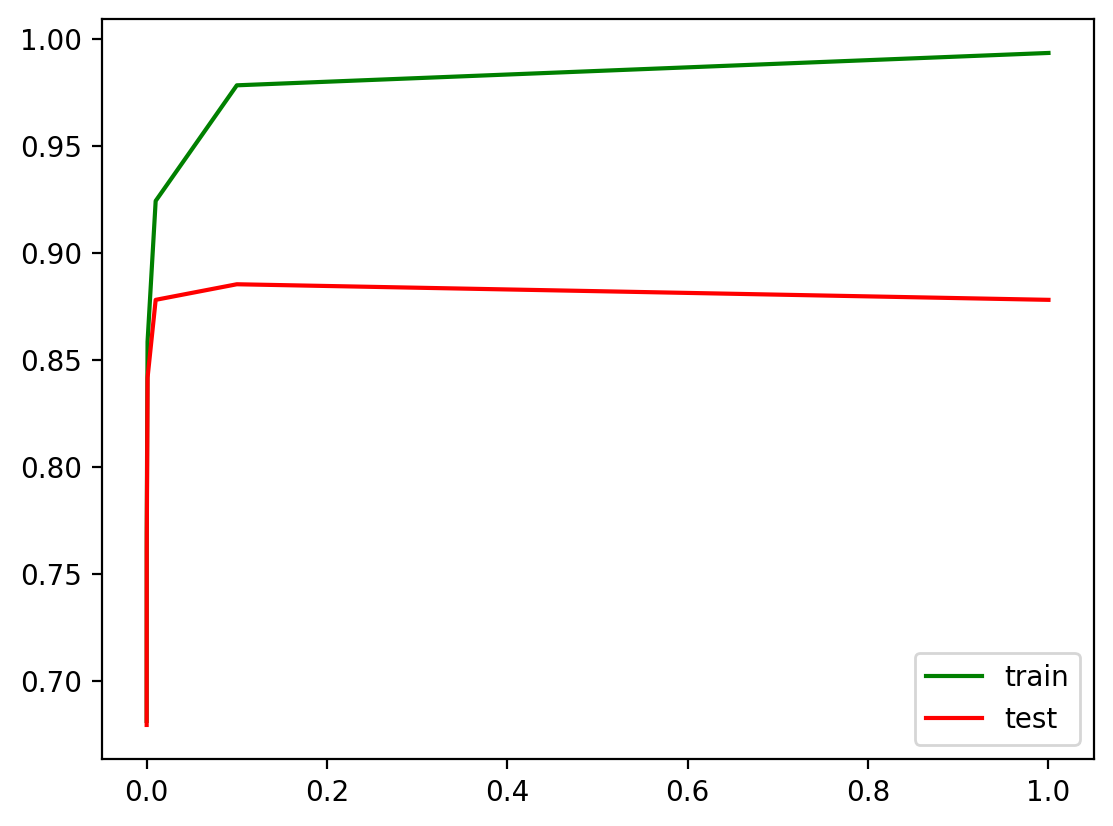

In [35]:
plot_grid_scores(grid_logit , "logisticregression__C")

In [36]:
grid_logit.score(text_test , y_test)

0.87812

Now let’s do the same with random forest. We see that, with logistic regression, we achieve better accuracy with less effort.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200 , n_jobs=-1 , random_state=7)


forest.fit(X_train , y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
from sklearn.metrics import accuracy_score

X_pred = forest.predict(X_test)


accuracy_score(y_test , X_pred)

0.85416

## XOR Problem
Let’s now consider an example where linear models are worse.

Linear classification methods still define a very simple separating surface - a hyperplane. The most famous toy example of where classes cannot be divided by a hyperplane (or line) with no errors is “the XOR problem”.

XOR is the “exclusive OR”, a Boolean function with the following truth table:



![alt text](image.png)

In [39]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

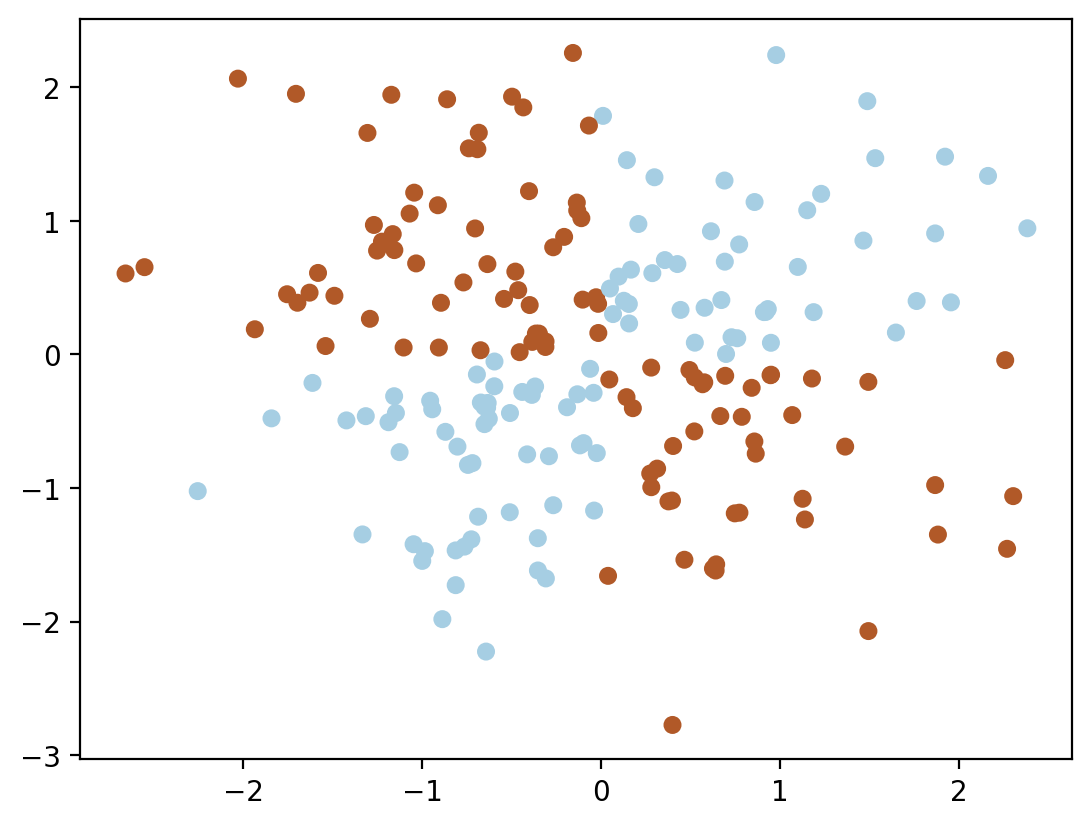

In [40]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Obviously, one cannot draw a single straight line to separate one class from another without errors. Therefore, logistic regression performs poorly with this task.

In [41]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

C:\Users\kvssr\AppData\Local\Temp\ipykernel_13144\3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


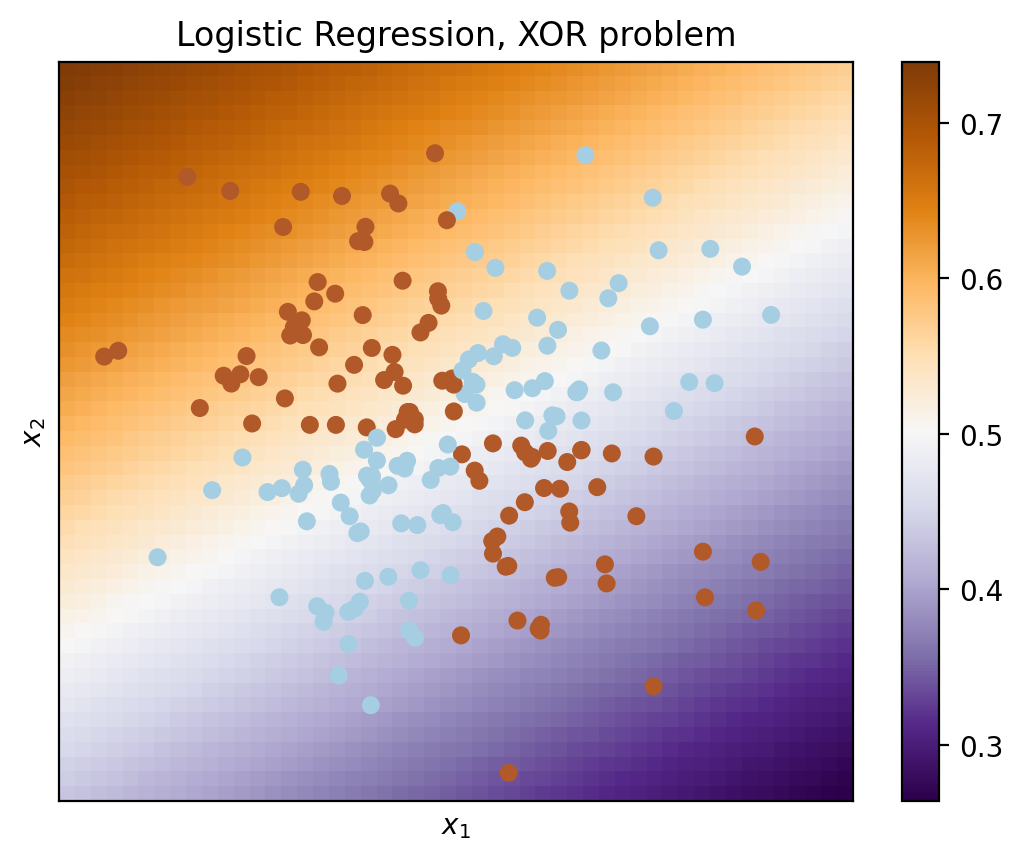

In [42]:
plot_boundary(
    LogisticRegression(solver="lbfgs"), X, y, "Logistic Regression, XOR problem"
)

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [44]:
logit_pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("logit", LogisticRegression(solver="lbfgs")),
    ]
)

C:\Users\kvssr\AppData\Local\Temp\ipykernel_13144\3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


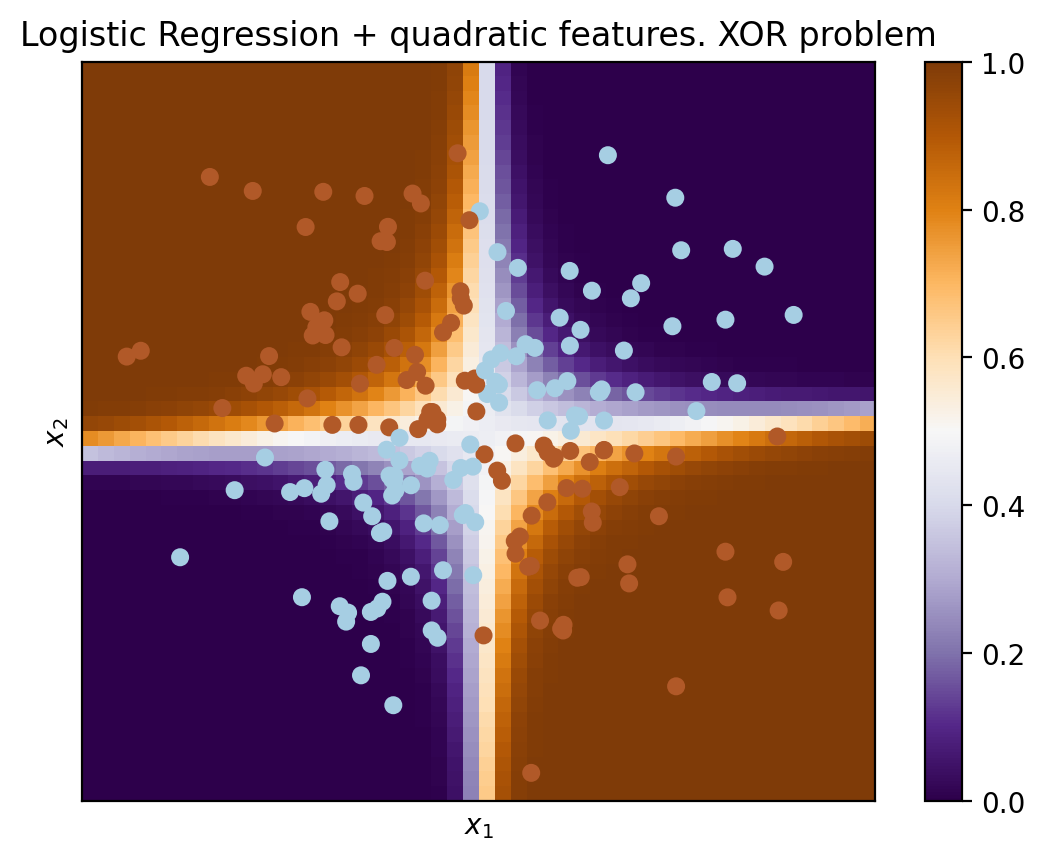

In [45]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")